<a href="https://colab.research.google.com/github/vrra/FGAN-Build-a-thon-2022/blob/main/build_a_thon_graph_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Build-a-thon 2022, Hoist the banners?

In [ ]:
!git clone https://github.com/vrra/FGAN-Build-a-thon-2022.git

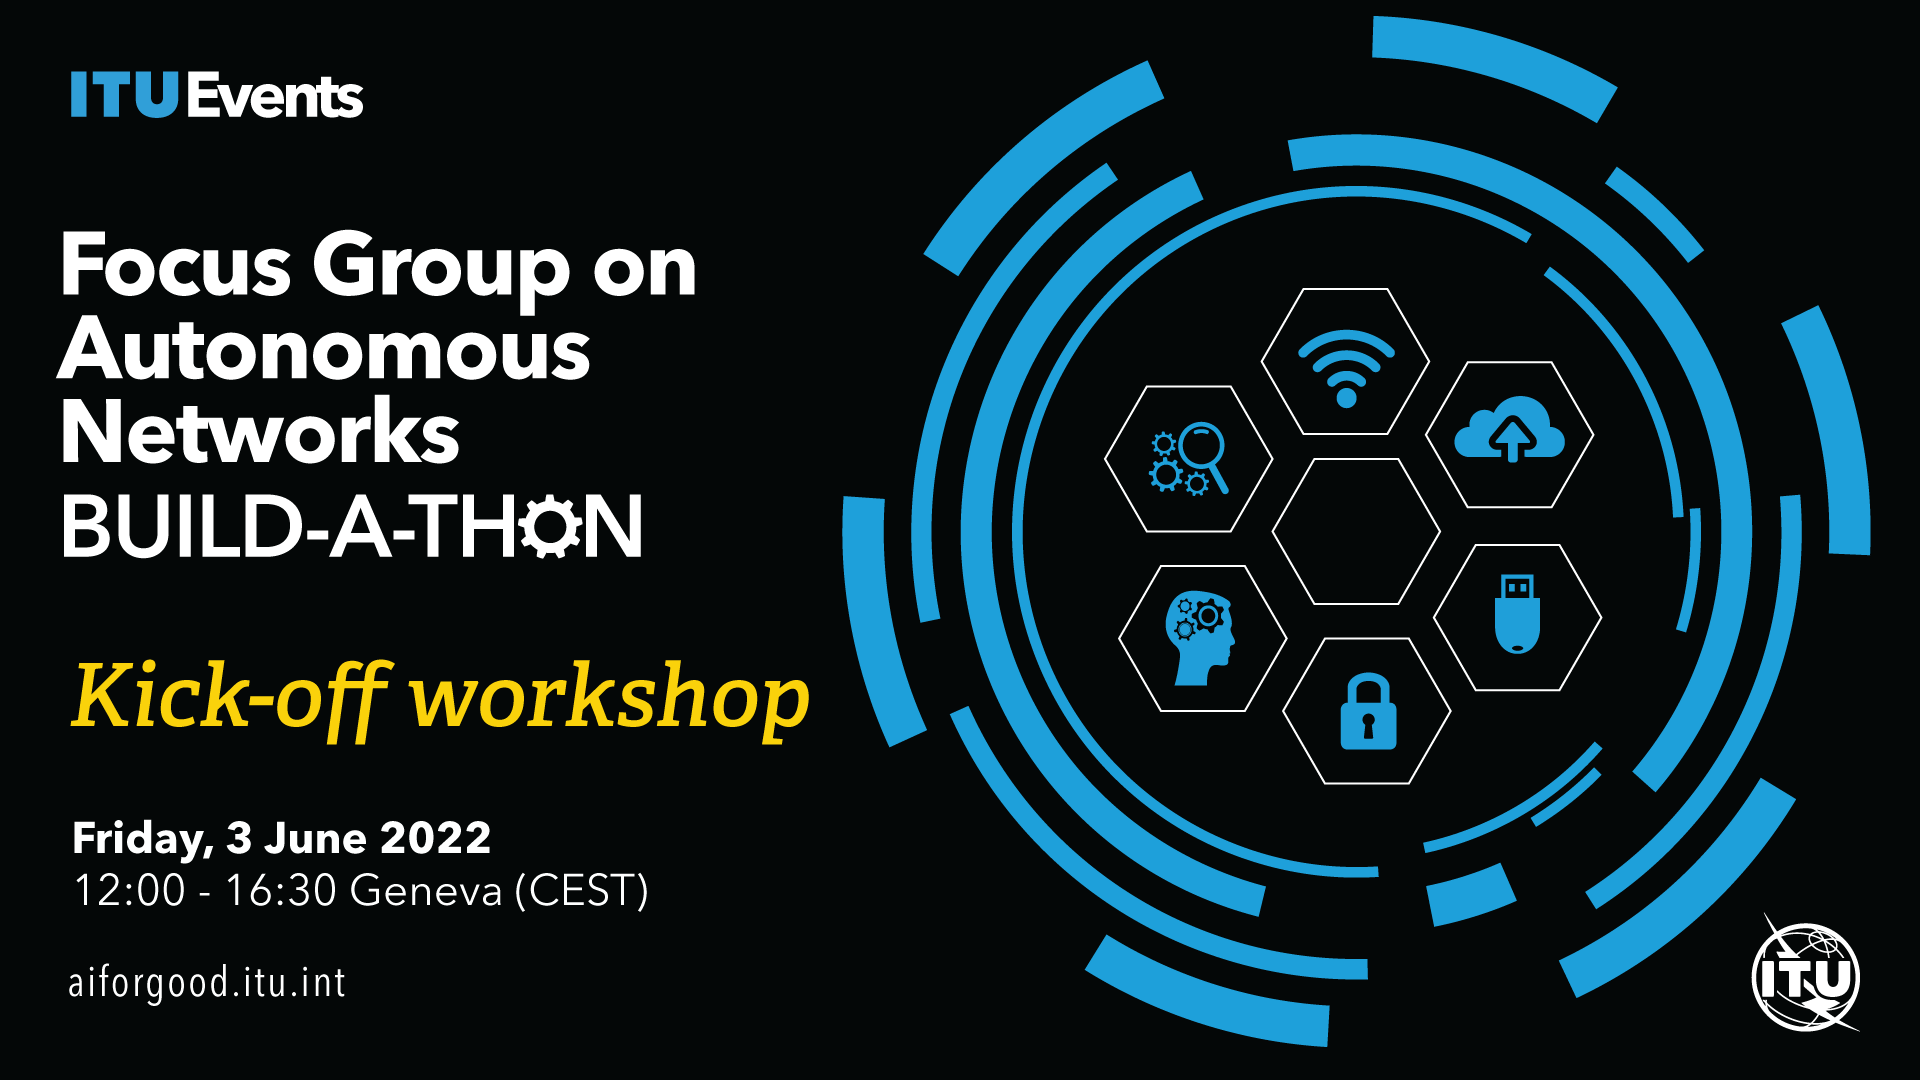

In [28]:
!cp FGAN-Build-a-thon-2022/Banner/1920x1080-FG_AN-buildathon.png /usr/local/share/jupyter/nbextensions/
from IPython.display import Image
Image(filename='/usr/local/share/jupyter/nbextensions//1920x1080-FG_AN-buildathon.png', width=500) 

##Introduction

Created: 14 Apr 2022.   
Author: Vishnu Ram OV.   
vishnu.n@ieee.org.   
Licence: available for all purposes under the sun  
but with acknowledgement and citation to "ITU FG AN Build-a-thon 2022"


##References 
[1] Neo4j Docs, "Creating an instance", https://neo4j.com/docs/aura/auradb/getting-started/create-database/   
[2] ITU-T Focus Group Autonomous Networks, "Use cases for Autonomous Networks", https://extranet.itu.int/sites/itu-t/focusgroups/an/output/FGAN-O-013-R1.docx  
[3] Build-a-thon github, https://github.com/vrra/FGAN-Build-a-thon-2022

##step-1: install neo4j

In [ ]:
pip install neo4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 5.6 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.4-py3-none-any.whl size=116554 sha256=a6d6435efd2d36c9cb7e3df038e601fe1219c97b4a9487be13b2da1997f2b63d
  Stored in directory: /root/.cache/pip/wheels/cf/c9/60/dab99fdca0093b46a9c9f5d5b99317c9d323c97d2f5af24e23
Successfully built neo4j


##step-2: imports and init

In [ ]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable

#Vishnu: 1 Jun 2022: use the details from https://console.neo4j.io
#especially use your own DB instance and corresponding passwd.

uri = "neo4j+s://a4270446.databases.neo4j.io"
user = "neo4j"
password = "secret"

#CAUTION: mask the instance and passwd after assignment.
#for demo purposes :)

##step-3: define helper class

In [ ]:


class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    #Vishnu: 1 Jun 2022: created this f() to create nodes with usecase label
    #Vishnu: 2 Jun 2022: added- check if it already exists.
    #Vishnu: 2 Jun 2022: added- check the label duplication, adds a label if it doesnt exist.
    #otherwise ignores the command.
    #uses _add_label_and_return_existing_node()
    def create_node_with_label(self, actor_name, usecase_id):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            node_already_exists = session.write_transaction(
                self._find_and_return_existing_node, actor_name)
            if not node_already_exists:  
                result = session.write_transaction(
                    self._create_and_return_node, actor_name, usecase_id)
                for row in result:
                    print("Created node: {n1}".format(n1=row['n1']))
            else:
                for row in node_already_exists:
                    print("Node already exists: {name} in {usecase}".format(name=row['name'], 
                                                                 usecase=row['label']))
                    if not any(usecase_id in s for s in row['label']):
                      print("adding label "+usecase_id+ "...")
                      result = session.write_transaction(
                                self._add_label_and_return_existing_node, actor_name, usecase_id)
                    else:
                      print("ignoring ...")


    #Vishnu: 2 Jun 2022: created this f() to query nodes and return with usecase label
    @staticmethod
    def _find_and_return_existing_node(tx, actor_name):
        query = (
            "MATCH (n:Actor) "
            "WHERE (n.name ='" + actor_name + "') "
            "RETURN n.name as name, labels(n) as label"
        )
        result = tx.run(query)
        try:
            return [{"name": row["name"],"label": row["label"]} 
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    @staticmethod
    def _create_and_return_node(tx, actor_name, usecase_id):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "CREATE (n1:Actor:"+usecase_id+"{ name: $actor_name }) "
            "RETURN n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Jun 2022: created this f() to add use case label to existing nodes 
    #CAUTION: does not check for duplication, use create_node_with_label instead.
    def add_label_existing_node(self, actor_name, usecase_id):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._add_label_and_return_existing_node, actor_name, usecase_id)
            
            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added label to node: {n1}".format(n1=row['n1']))

    @staticmethod
    def _add_label_and_return_existing_node(tx, actor_name, usecase_id):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MATCH "
            "(n1:Actor) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1 :"+usecase_id +" "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Jun 2022: created this f() to create relation between 2 existing nodes
    def create_rel_with_type_existing_nodes(self, actor1_name, rel_type, actor2_name):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._create_and_return_rel_with_type_existing_nodes, rel_type, actor1_name, actor2_name)
            for row in result:
                print("Created relation between: {n1}, {n2}".format(n1=row['n1'], n2=row['n2']))

    @staticmethod
    def _create_and_return_rel_with_type_existing_nodes(tx, rel_type, actor1_name, actor2_name):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MATCH "
            "(n1:Actor), "
            "(n2:Actor) "
            "WHERE n1.name = '" + actor1_name + "' AND n2.name = '"+actor2_name+"' "
            "CREATE (n1)-[r:" +rel_type+ "]->(n2) "
            "RETURN n1, n2"
        )
        result = tx.run(query)
        try:
            return [{"n1": row["n1"]["name"], "n2": row["n2"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Jun 2022: added relationships names
    #Vishnu: CAUTION: side-effect: this f() creates the nodes too.
    #NOTE: we use labels and properties for nodes
    #NOTE: we use relationtypes only (vs. properties or names or something)
    #NOTE: usecase id is just a string (vs. a list of properties or something)
    #TBD - to search for existing nodes and reuse them.
    #TBD - add properties to relationships
    def create_nodes_with_friendship(self, actor1_name, actor2_name, rel_type, usecase_id):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._create_and_return_friendship, actor1_name, actor2_name, rel_type, usecase_id)
            for row in result:
                print("Created friendship between: {n1}, {n2}".format(n1=row['n1'], n2=row['n2']))
    
    @staticmethod
    def _create_and_return_friendship(tx, actor1_name, actor2_name, rel_type, usecase_id):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "CREATE (n1:Actor:"+usecase_id+"{ name: $actor1_name }) "
            "CREATE (n2:Actor:"+usecase_id+"{ name: $actor2_name }) "
            "CREATE (n1)-[:" + rel_type + "]->(n2) "
            "RETURN n1, n2"
        )
        result = tx.run(query, actor1_name=actor1_name, actor2_name=actor2_name)
        try:
            return [{"n1": row["n1"]["name"], "n2": row["n2"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Jun 2022: created this f() to list all nodes with usecase label
    def find_all_usecase_actors(self, usecase_id):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_all_usecase_actors, usecase_id)
            i=0
            for row in result:
                i=i+1
                print("Found actor-"+ str(i) +": {row}".format(row=row))

    @staticmethod
    def _find_and_return_all_usecase_actors(tx, usecase_id):
        query = (
            "MATCH (n:Actor:"+usecase_id+") "
            "RETURN n.name AS name"
        )
        result = tx.run(query)
        return [row["name"] for row in result]

##step-4: instantiate the helper class to DB. 
CAUTION: this uses the username/passwd assigned already in step-2 above.

In [ ]:
app = App(uri, user, password)

##Examples

###Example-1: Create individual nodes with labels

In [ ]:
app.create_node_with_label("Experimentation Controller", "usecase_001")
app.create_node_with_label("Sandbox", "usecase_001")


###Example-1a: try to create duplicate node under different use case

In [ ]:
app.create_node_with_label("Sandbox", "usecase_003")


###Example-2: Create relation between 2 existing nodes

In [ ]:
app.create_rel_with_type_existing_nodes("Experimentation Controller", "my_best_buddy", "Sandbox")


###Example-3: add a use case label to existing node

In [ ]:
app.add_label_existing_node("Experimentation Controller", "usecase_002")

###Example-4: Find all nodes with a use case label

In [ ]:
app.find_all_usecase_actors("usecase_001")

In [ ]:
app.find_all_usecase_actors("usecase_002")

CAUTION: Remember to clean up the DB before executing the next steps. (so that all examples above are not leftover in the use case data below).



---



##USECASES

###FG-AN-USECASE-001

In [ ]:
app.create_node_with_label("Knowledge Base", "usecase_001")
app.create_node_with_label("Knowledge Base Manager", "usecase_001")
app.create_node_with_label("AN Orchestrator", "usecase_001")
app.create_node_with_label("Use case description", "usecase_001")
app.create_node_with_label("TOSCA format", "usecase_001")
app.create_node_with_label("Auto controller generator", "usecase_001")
app.create_node_with_label("controller repository", "usecase_001")
app.create_node_with_label("controllers", "usecase_001")
app.create_node_with_label("ML model", "usecase_001")
app.create_node_with_label("Human operator", "usecase_001")
app.create_node_with_label("reports", "usecase_001")



In [ ]:
app.create_rel_with_type_existing_nodes("Knowledge Base", "import", "Knowledge Base")
app.create_rel_with_type_existing_nodes("Knowledge Base", "export", "Knowledge Base")

app.create_rel_with_type_existing_nodes("Knowledge Base Manager", "optimizes", "Knowledge Base")
app.create_rel_with_type_existing_nodes("Knowledge Base Manager", "export", "Knowledge Base")

app.create_rel_with_type_existing_nodes("AN Orchestrator", "refer", "Knowledge Base")
app.create_rel_with_type_existing_nodes("AN Orchestrator", "input", "Use case description")
app.create_rel_with_type_existing_nodes("AN Orchestrator", "output", "TOSCA format")

app.create_rel_with_type_existing_nodes("Auto controller generator", "refer", "Knowledge Base")
app.create_rel_with_type_existing_nodes("Auto controller generator", "output", "TOSCA format")

app.create_rel_with_type_existing_nodes("controller repository", "stores", "controllers")
app.create_rel_with_type_existing_nodes("ML model", "recommends", "controllers")

app.create_rel_with_type_existing_nodes("Human operator", "input", "reports")
app.create_rel_with_type_existing_nodes("Human operator", "monitors", "reports")





NOTE- verify atleast the actors.   
Also verify from the console of neo4j

In [ ]:
app.find_all_usecase_actors("usecase_001")

###FG-AN-USECASE-002


NOTE- in case of duplicate actors, only the use case label will be added.  
So, to help search based on use case label, make sure to add the actor, even if there is duplication among use cases.

In [ ]:
app.create_node_with_label("Experimentation controller", "usecase_002")
app.create_node_with_label("scenarios for experimentation", "usecase_002")
app.create_node_with_label("AN sandbox", "usecase_002")
app.create_node_with_label("simulators", "usecase_002")
app.create_node_with_label("reports", "usecase_002")
app.create_node_with_label("experiments", "usecase_002")
app.create_node_with_label("Knowledge Base", "usecase_002")



In [ ]:
app.create_rel_with_type_existing_nodes("Experimentation controller", "decides", 
                                        "scenarios for experimentation")

app.create_rel_with_type_existing_nodes("AN sandbox", "hosts", 
                                        "simulators")
app.create_rel_with_type_existing_nodes("AN sandbox", "manages", 
                                        "simulators")
app.create_rel_with_type_existing_nodes("AN sandbox", "output", 
                                        "reports")

app.create_rel_with_type_existing_nodes("Experimentation controller", "triggers", 
                                        "experiments")
app.create_rel_with_type_existing_nodes("Experimentation controller", "output", 
                                        "reports")
app.create_rel_with_type_existing_nodes("Experimentation controller", "executes", 
                                        "experiments")
app.create_rel_with_type_existing_nodes("Experimentation controller", "monitors", 
                                        "experiments")
app.create_rel_with_type_existing_nodes("Experimentation controller", "uses", 
                                        "AN sandbox")
app.create_rel_with_type_existing_nodes("Experimentation controller", "updates", 
                                        "Knowledge Base")

app.create_rel_with_type_existing_nodes("experiments", "has", 
                                        "scenarios for experimentation")

In [ ]:
app.find_all_usecase_actors("usecase_002")

###FG-AN-USECASE-003


In [ ]:
app.create_node_with_label("AN Orchestrator", "usecase_003")
app.create_node_with_label("Human operator", "usecase_003")
app.create_node_with_label("feedback", "usecase_003")
app.create_node_with_label("Knowledge Base", "usecase_003")
app.create_node_with_label("AN components", "usecase_003")


In [ ]:
app.create_rel_with_type_existing_nodes("AN Orchestrator", "queries", 
                                        "AN Orchestrator")
app.create_rel_with_type_existing_nodes("AN Orchestrator", "queries", 
                                        "Human operator")
app.create_rel_with_type_existing_nodes("AN Orchestrator", "accept", 
                                        "feedback")
app.create_rel_with_type_existing_nodes("AN Orchestrator", "configures", 
                                        "AN components")
app.create_rel_with_type_existing_nodes("AN Orchestrator", "updates", 
                                        "Knowledge Base")


###FG-AN-USECASE-004


In [ ]:
app.create_node_with_label("Adaptation controller", "usecase_004")
app.create_node_with_label("controllers", "usecase_004")
app.create_node_with_label("controller repository", "usecase_004")
app.create_node_with_label("Knowledge Base", "usecase_004")



In [ ]:
app.create_rel_with_type_existing_nodes("AN Orchestrator", "queries", 
                                        "AN Orchestrator")



---



Step-5: Close the database connection

In [ ]:
app.close()